(1400L, 1L)
Fit Model 0 fold 0
Fit Model 0 fold 1


KeyboardInterrupt: 

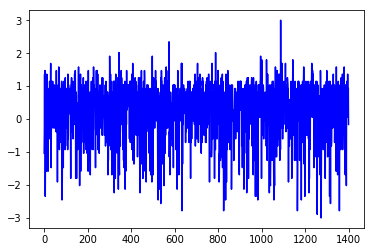

In [43]:
# coding:utf-8
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import os
import numpy.random as npr
from datetime import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import math
from sklearn import metrics
# data precession
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
# model
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from  sklearn.model_selection  import  train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from math import sqrt
x=np.load('D:/ser/Train/opensmile_features1582.npy')
x_test=np.load('D:/ser/Test/opensmile_features1582.npy')
X=x.astype(float)
x_test=x_test.astype(float)
y=np.loadtxt('D:/ser/Train/P_Train_27KB.txt')
y=np.array(y)
y=pd.DataFrame(y,columns=['id','P'])
s=y.P
id=y.drop('P',axis=1)
Y=np.array(s)
# y=np.loadtxt('D:/ser/Train/P_Train_27KB.txt')
# y=np.array(y)
# y=pd.DataFrame(y,columns=['id','P'])
# s=y.P
# Y=np.array(s)
# print X.shape
Y=Y.reshape(-1,1)

le=MinMaxScaler(feature_range=(-3,3))
le.fit(Y)
Y=le.transform(Y)
print Y.shape
train_x,valid_x,train_y,valid_y=train_test_split(X,Y,test_size=0.2,random_state=0)
plt.plot(Y,c='b')

# plt.title('P_Train')
# plt.legend(['Y'])
# le.fit(X)
# Y=le.transform(X)
# plt.plot(X,c='r')
#
# plt.title('X')
# plt.legend(['real'])


def calcMean(x,y):
    sum_x = sum(x)
    sum_y = sum(y)
    n = len(x)
    x_mean = float(sum_x+0.0)/n
    y_mean = float(sum_y+0.0)/n
    return x_mean,y_mean
def pc(x,y):
    x_mean,y_mean = calcMean(x,y)
    n = len(x)
    sumTop = 0.0
    sumBottom = 0.0
    x_pow = 0.0
    y_pow = 0.0
    for i in range(n):
        sumTop += (x[i]-x_mean)*(y[i]-y_mean)
    for i in range(n):
        x_pow += math.pow(x[i]-x_mean,2)
    for i in range(n):
        y_pow += math.pow(y[i]-y_mean,2)
    sumBottom = math.sqrt(x_pow*y_pow)
    p = sumTop/sumBottom
    return p



#Ensemble class


class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                y_holdout = y[test_idx]
                print ("Fit Model %d fold %d" % (i, j))
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]
            S_test[:, i] = S_test_i.mean(axis=1)

        # results = cross_val_score(self.stacker, S_train, y, cv=5, scoring='r2')
        # print("Stacker score: %.4f (%.4f)" % (results.mean(), results.std()))
        # exit()

        self.stacker.fit(S_train, y)
        res = self.stacker.predict(S_test)[:]
        return res

# rf params
rf_params = {}
rf_params['n_estimators'] = 50
rf_params['max_depth'] = 8
rf_params['min_samples_split'] = 100
rf_params['min_samples_leaf'] = 30

# xgb params
xgb_params = {}
# xgb_params['n_estimators'] = 50
xgb_params['min_child_weight'] = 12
xgb_params['learning_rate'] = 0.37
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.77
xgb_params['reg_lambda'] = 0.8
xgb_params['reg_alpha'] = 0.4
xgb_params['base_score'] = 0
# xgb_params['seed'] = 400
xgb_params['silent'] = 1

# lgb params
lgb_params = {}
# lgb_params['n_estimators'] = 50
lgb_params['max_bin'] = 8
lgb_params['min_bin'] = 1
lgb_params['min_data_in_bin'] = 1
lgb_params['learning_rate'] = 0.37  # shrinkage_rate
lgb_params['metric'] = 'l1'  # or 'mae'
lgb_params['sub_feature'] = 0.35
lgb_params['bagging_fraction'] = 0.85  # sub_row
lgb_params['bagging_freq'] = 40
lgb_params['num_leaves'] = 512  # num_leaf
lgb_params['min_data'] = 500  # min_data_in_leaf
lgb_params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf
lgb_params['verbose'] = 0
lgb_params['feature_fraction_seed'] = 2
lgb_params['bagging_seed'] = 3

# XGB model
xgb_model = XGBRegressor(**xgb_params)

# lgb model
lgb_model = LGBMRegressor(**lgb_params)

# RF model
rf_model = RandomForestRegressor(**rf_params)

# ET model
et_model = ExtraTreesRegressor()

# SVR model
# SVM is too slow in more then 10000 set
svr_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)

# DecsionTree model
dt_model = DecisionTreeRegressor()

# AdaBoost model
ada_model = AdaBoostRegressor()

stack = Ensemble(n_splits=5,
                 stacker=LinearRegression(),
                 base_models=(rf_model, xgb_model, et_model, ada_model))

y_pre = stack.fit_predict(train_x, train_y.ravel(), x_test)

from datetime import datetime



print y_pre
# pre_vaild = y_valid


# print "the result of 1582 dimensional features"
# #metrics model
# mse=metrics.mean_squared_error(pre_vaild,valid_y)
# rmse=np.sqrt(mse)
# r2=metrics.r2_score(pre_vaild,valid_y)
# pcc=pc(pre_vaild,valid_y)
# print 'pcc:{}'.format(pcc)
# print 'mse:{}'.format(mse)
# print 'rmse:{}'.format(rmse)
# print 'r2:{}'.format(r2)



#plt predicted and real
# plt.plot(y_test,c='r')
# plt.plot(test_y,c='g')
# plt.title('predicted and real')
# plt.legend(['predicted','real'])

In [28]:
y_pre=np.array(y_pre)
y_pre=y_pre.ravel()
y_id=range(11401,12001)
y_id=np.array(y_id)
new_dict = dict(zip(y_id, y_pre))


[ 0.48968769  0.44135501  1.08245111  0.4524967   0.16170452 -0.26374402
  0.85588071  0.0556564   0.55593289  1.0196239  -0.586134    0.85767231
  0.23750796 -0.62438556 -0.47507741  1.07604262  0.53516191  0.78408377
  0.77903347 -2.04648848  1.02069137  0.43797041  0.21535017  0.66874355
 -1.02821316 -0.35600696  0.80785564 -0.25280493 -0.02778766 -0.34718471
  0.49720578  0.61574845  0.14664739  0.28440754  0.35186004  0.60366127
  0.23708203  0.80633262  0.6650416  -0.09192742  0.7172958  -1.06120027
  0.84810828 -0.73188722 -0.92553271  0.8084232  -0.70967464  0.5598471
 -0.43808523  0.47586235  0.21541965  0.92790185 -0.09847224 -0.98348163
 -0.18349695  0.37739507  0.06396591  1.01489591  0.20131041  0.27611018
  1.03056451 -1.95070322 -0.3853117   0.33711205  1.07320833 -1.49547006
  0.14969924  0.21509395  0.67257141  0.99312967  0.04344625  0.07434737
  0.39903556  0.77435359  0.54828919  0.44167725  1.03219707  0.01355527
  0.9205262   0.41714126  0.67801526  0.08115763 -0.

In [32]:
import json
json.dumps(new_dict, sort_keys=True, separators=('\n','\t'))


'{"11401"\t0.48968769114924393\n"11402"\t0.44135501499582663\n"11403"\t1.082451108884729\n"11404"\t0.4524967031742211\n"11405"\t0.16170451977013658\n"11406"\t-0.2637440176081052\n"11407"\t0.8558807056420514\n"11408"\t0.05565640167149123\n"11409"\t0.5559328891581675\n"11410"\t1.0196238957202728\n"11411"\t-0.5861340009858902\n"11412"\t0.8576723142169203\n"11413"\t0.23750795701307922\n"11414"\t-0.6243855649490669\n"11415"\t-0.475077412637975\n"11416"\t1.0760426153662526\n"11417"\t0.5351619060868449\n"11418"\t0.7840837698343333\n"11419"\t0.7790334688374012\n"11420"\t-2.0464884841918827\n"11421"\t1.020691374727375\n"11422"\t0.4379704053995407\n"11423"\t0.2153501686851879\n"11424"\t0.6687435522616666\n"11425"\t-1.0282131643068628\n"11426"\t-0.3560069592930112\n"11427"\t0.8078556439936897\n"11428"\t-0.25280493488444133\n"11429"\t-0.027787659072556495\n"11430"\t-0.3471847111018981\n"11431"\t0.49720577995535764\n"11432"\t0.6157484481885521\n"11433"\t0.14664739072190405\n"11434"\t0.2844075407117

In [42]:
with open("C:/Users/Administrator/Desktop/Emotion-Recognition-from-Speech-master/Emotion-Recognition-from-Speech-master/src/submission_sample.json","w") as f:
    json.dump(new_dict,f,separators=('\n','\t'))


In [41]:
help(json.dump)

Help on function dump in module json:

dump(obj, fp, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, encoding='utf-8', default=None, sort_keys=False, **kw)
    Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
    ``.write()``-supporting file-like object).
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``unicode``, ``int``, ``long``, ``float``, ``bool``, ``None``)
    will be skipped instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is true (the default), all non-ASCII characters in the
    output are escaped with ``\uXXXX`` sequences, and the result is a ``str``
    instance consisting of ASCII characters only.  If ``ensure_ascii`` is
    false, some chunks written to ``fp`` may be ``unicode`` instances.
    This usually happens because the input contains unicode strings or the
    ``encoding`` parameter is used. Unless ``fp.write()`` explicitly
    unders